In [ ]:
import matplotlib.pyplot as plt
from scipy.sparse import diags,csr_matrix
from scipy.integrate import simpson
from scipy.sparse.linalg import spsolve,eigsh
import numpy as np
import sympy as sp

In [3]:
def fd_weights ( offsets , order , show_system = False ) :

    """
    Name          : fd_weights -> finite difference weights
    Purpose       : calculate the set of coefficients for a finite difference
                    approximation of the order-th derivative using the given
                    offsets. We are essentually solving the linear system
                    A c = b, where A is the Vandermonde matrix of the offsets,
                    c is the vector of coefficients we want to find, and b is
                    a vector of zeros with a factorial(order) in the order-th
                    position.
    Author          : christlieb, augmented by Joshua Belieu.
    Date augmented  : 2025-08-26
    Last modified   : 2025-08-26
    Inputs :
        - offsets     : list. list of offsets (in units of grid stride h)
        - order       : int. order of derivative to approximate
        - show_system : bool. if True, print the system of equations being
                        solved. default is False.
    Outputs:
        - <ret>: <type> ... <meaning/units/shape>
    Dependencies:
        - None.
    """

    '''
    list of offsets (in units of grid stride h), nsimplify allows floats.
    '''

    s = [ sp.nsimplify ( offset ) for offset in offsets ]
    m = len ( s )

    '''
    the Vandermonde matrix of the offsets. the "A" in our system Ac = b
    '''

    A = sp.Matrix ([[ s[j] ** k for j in range ( m ) ] for k in range ( m )])

    '''
    a vector of zeros with a factorial(order) in the order-th position. the 
    "b" in our system Ac = b.
    '''

    b = sp.Matrix ( [ 0 ] * m )
    b [ order ] = sp.factorial ( order )

    '''
    the coefficients we want to find. the "c" in our system Ac = b. LUsolve is 
    a decomposition method that splits A into a lower and upper triangular matrix
    and solves the system (Ux=y and Ly=c) in two steps.
    '''

    c = A.LUsolve ( b )

    if show_system :

        system = sp.Eq( sp.MatMul ( A , c , evaluate = False ) , b )
        sp.pprint(system)

    return sp.simplify ( c )

h not specified, assuming h = 1.0
<class 'numpy.ndarray'>


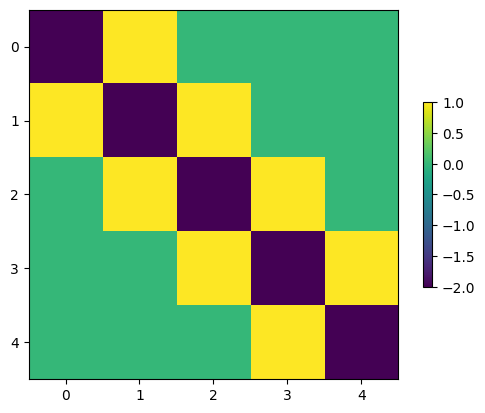

In [4]:
def derivative_1d_stencil ( n = 5 , offsets = [-1,0,1] , order = 2 , h = None ) :

    """
    Name: derivative_1d_stencil
    Purpose: what this subroutine computes and why
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-24
    Last modified: 2025-09-24
    Inputs:
    - arg1: type ... meaning/units/shape
    - arg2: type ... meaning/units/shape
    Outputs:
    - ret: type ... meaning/units/shape
    Dependencies:
    - SubroutineA, SubroutineB, ...
    """

    if h == None :
        print ( "h not specified, assuming h = 1.0" )
        h = 1.0

    weights = [ float(num) for num in np.array(fd_weights ( offsets , order )).flatten()]

    stencil = diags ( weights , offsets , shape = ( n , n ) ) / h**order

    return stencil.toarray()

'''
unit test
'''
test_deriv = derivative_1d_stencil()
print(type(test_deriv))
plt.imshow(test_deriv)
plt.colorbar(shrink=0.5);

0.1.c

In [9]:
def spectral_radius ( matrix ) :

    """
    Name: spectral_radius
    Purpose: compute the spectral radius of a given matrix
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-09-30
    Inputs:
    - matrix : ndarray/sparse matrix. the matrix to find the spectral radius of.
    Outputs:
    - max_eigenval : float. the absolute value of the largest eigenval
    Dependencies:
    - None.
    """

    eigenvals , eigenvecs = eigsh ( matrix )

    max_eigenval = np.max ( np.abs ( eigenvals ) )

    return max_eigenval

Final Stats : 
 Iteration : 2423 
 ||Error|| : 1.00e-10


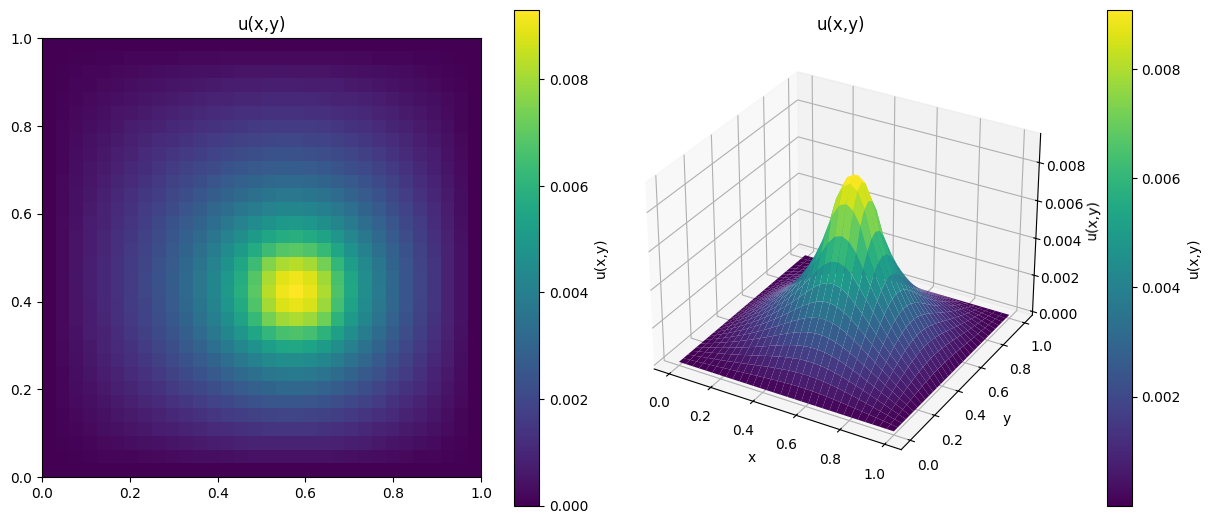

In [68]:
def jacobi_iteration ( b , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: jacobi_iteration
    Purpose: use the jacobi iteration method to solve an ODE/PDE
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-09-30
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = np.inf
    iteration = 0

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * ( u[i+1] + u[i-1] ) - h ** 2 / 4 * b[i]
                error = u_new - u
                u = u_new
                iteration += 1
    
    elif b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * ( u[i,j+1] + u[i,j-1] + u[i+1,j] + u[i-1,j] ) - h ** 2 / 4 * b[i,j]
            error = u_new - u
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print(out_str)

    return u

'''
unit test
'''

n = 32
b = np.zeros((n,n))
x = np.linspace ( 0 , 1 , n );
y = np.linspace ( 0 , 1 , n );
for i in range ( n ) :
    for j in range ( n ) :
        if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
            b[i,j] = -1

u_sol = jacobi_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
X, Y = np.meshgrid(x, x)

fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
ax1 = fig.add_subplot ( 121 )
ax2 = fig.add_subplot ( 122 , projection = '3d' )

im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
ax1.set_title("u(x,y)")

im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u(x,y)")
ax2.set_title("u(x,y)");

1.5.b

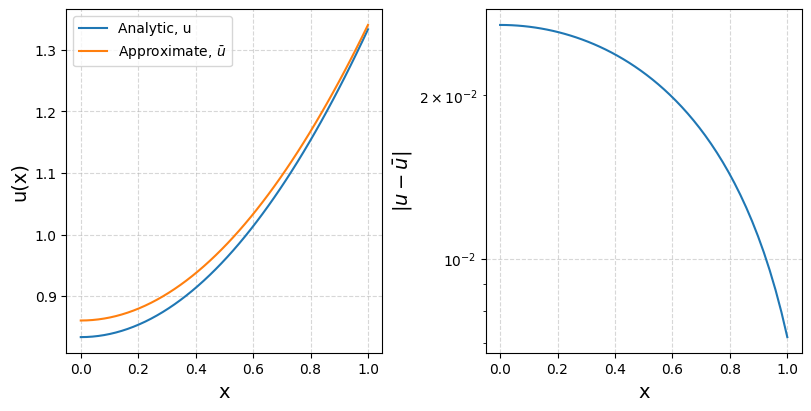

In [ ]:
x_low = 0.
x_high = 1.
n = int(5e1)
h = x_high / ( n )

offsets = [ -1 , 0 , 1 ]
derivative_matrix = derivative_1d_stencil(n,h=h)
stencil_nobc = derivative_matrix.copy()
left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2],1 )).flatten()])
# right_neumann = np.array([float(num) for num  in np.array(fd_weights ( [-2,-1,0],1 )).flatten()])

derivative_matrix[0,0:3] = left_neumann / h
# derivative_matrix[-1,-3:] = right_neumann / h

f = np.ones ( n-1 )
f[0]=0.

norm_cond = np.ones ( n ) * h
norm_cond[0]=h/2;norm_cond[-1]=h/2
derivative_matrix[-1,:] = norm_cond
f = np.append(f,1.0)

# u = np.linalg.lstsq ( derivative_matrix , f ,rcond=None)[0]
u = spsolve ( csr_matrix(derivative_matrix) , f )
# u_norm = simpson ( u , dx = h )
# print(u_norm)
# u /= u_norm
# print(simpson(u,dx=h))

x = np.linspace ( x_low , x_high , n )
true = 0.5*x**2+5/6

fig,axs = plt.subplots(1,2,figsize=(8,4),constrained_layout=True)
# plt.figure(figsize=(8,6))
axs[0].plot( x , true ,label='Analytic, u')
axs[0].plot( x , u , label = r'Approximate, $\bar{u}$')
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('u(x)', fontsize=14)
axs[0].grid(ls='--',alpha=0.5)
axs[1].plot( x , np.abs(u - true))
axs[1].set_xlabel('x', fontsize=14)
axs[1].set_ylabel(r'$|u-\bar{u}|$', fontsize=14)
axs[1].set_yscale('log')
axs[1].grid(ls='--',alpha=0.5)
axs[0].legend();
# plt.imshow(derivative_matrix);

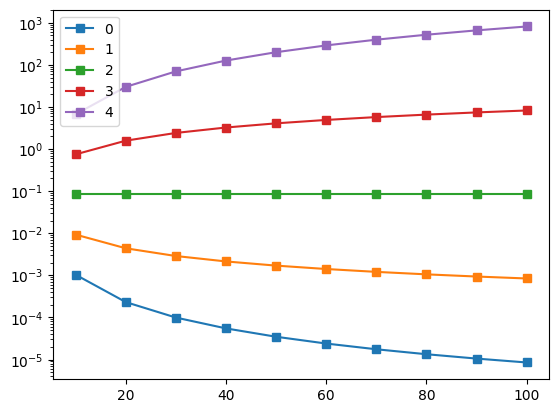

In [7]:
x_low = 0.
x_high = 1.
n_list = range(10,110,10)

offsets = [ -1 , 0 , 1 ]
h_list = []
max_error_list = []

for n in n_list : 

    h = x_high / ( n-1 )

    derivative_matrix = derivative_1d_stencil(n,h=h)

    left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2,3],1 )).flatten()])
    # right_neumann = np.array([float(num) for num  in np.array(fd_weights ( [-1,0],1 )).flatten()])

    derivative_matrix[0,0:len(left_neumann)] = left_neumann / h
    # derivative_matrix[-1,-len(right_neumann):] = right_neumann / h

    f = np.ones ( n-1 )
    f[0]=0.

    norm_cond = np.ones ( n ) * h
    norm_cond[0]=h/2;norm_cond[-1]=h/2
    derivative_matrix[-1,:] = norm_cond
    f = np.append(f,1.0)

    # u = np.linalg.lstsq ( derivative_matrix , f ,rcond=None)[0]
    u = spsolve ( csr_matrix(derivative_matrix) , f )    
    # u_norm = simpson ( u , dx = h )
    # u /= u_norm
    x = np.linspace ( x_low , x_high , n )
    true = 0.5*x**2+5/6

    h_list.append(h)
    max_error_list.append ( np.max ( np.abs ( u - true )))
for order in range ( 0 , 4 + 1 ) :
    plt.plot ( n_list , np.array(max_error_list)/np.array(h_list)**order ,label=order,marker='s')
plt.yscale('log')
plt.legend();